# Code

In [14]:
import sys
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch

from w2s.relabel import RESULT_DIR
from w2s.roc_auc import roc_auc
from w2s.ds_registry import load_and_process_dataset
from w2s.relabel import compute_metrics

In [5]:
def get_results(outfile='relabel.json'):
    out_dir = RESULT_DIR.format(user="adam")
    out_file = Path(out_dir) / outfile

    # get existing results
    with open(out_file, 'r') as f:
        all_results = json.load(f)

    return all_results

In [6]:
all_results = get_results()
len(all_results)

100

In [7]:
def plot_method(all_results, method, param='kzeta', **kwargs):
    results = [r for r in all_results if r['method'] == method]

    if len(results) == 0:
        print(f"No results for method {method}")
        return

    # grid of plots
    num_ds = len(results)
    metrics = results[0]['metrics'].keys()
    num_metrics = len(metrics)

    print(f"num_ds: {num_ds}, num_metrics: {num_metrics}")

    # make it square-ish
    num_rows = 2 * num_metrics
    num_cols = int(np.ceil(num_ds / 2))

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

    for i, result in enumerate(results):
        assert result['method'] == method
        ds = result['dataset']

        xs = result['params'][param]

        for j, metric in enumerate(metrics):
            assert metric in result['metrics']
            assert metric in result['baseline_metrics']
            vals = result['metrics'][metric]
            baseline = result['baseline_metrics'][metric]

            row = num_metrics * (i // num_cols) + j
            col = i % num_cols

            ax = axs[row, col]
            ax.plot(xs, vals, label=method)
            ax.plot(xs, [baseline]*len(xs), label='baseline')
            if 'log' in kwargs:
                ax.set_xscale('log')
            ax.set_xlabel(param)
            ax.set_ylabel(metric)
            ax.set_title(f"{ds} {metric}")
            ax.legend()

    plt.tight_layout()
    plt.show()

    

# Relabel plots

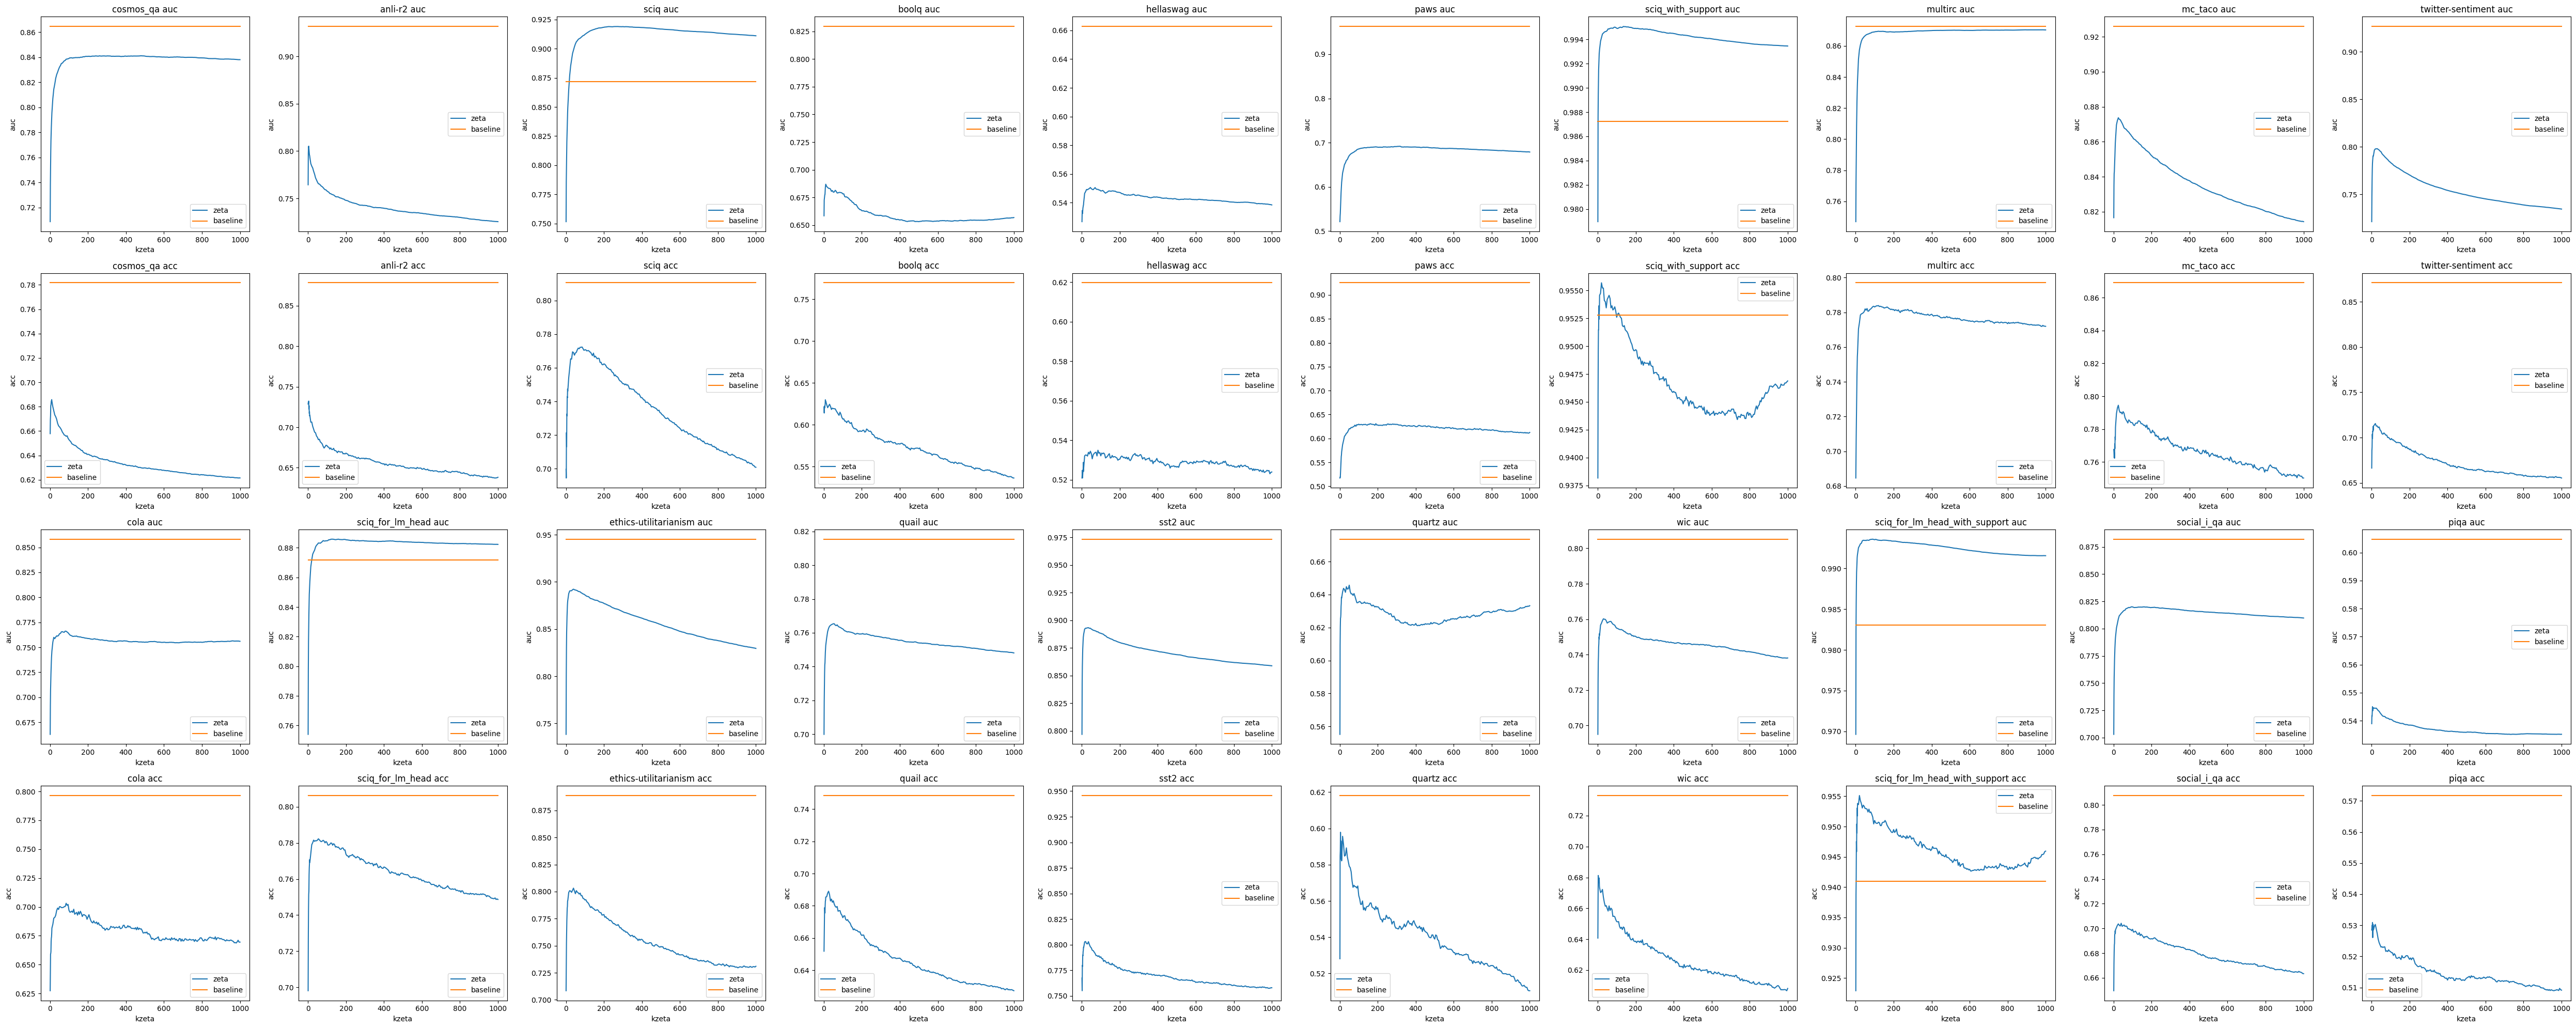

In [39]:
plot_method('zeta', 'kzeta')

num_ds: 20, num_metrics: 2


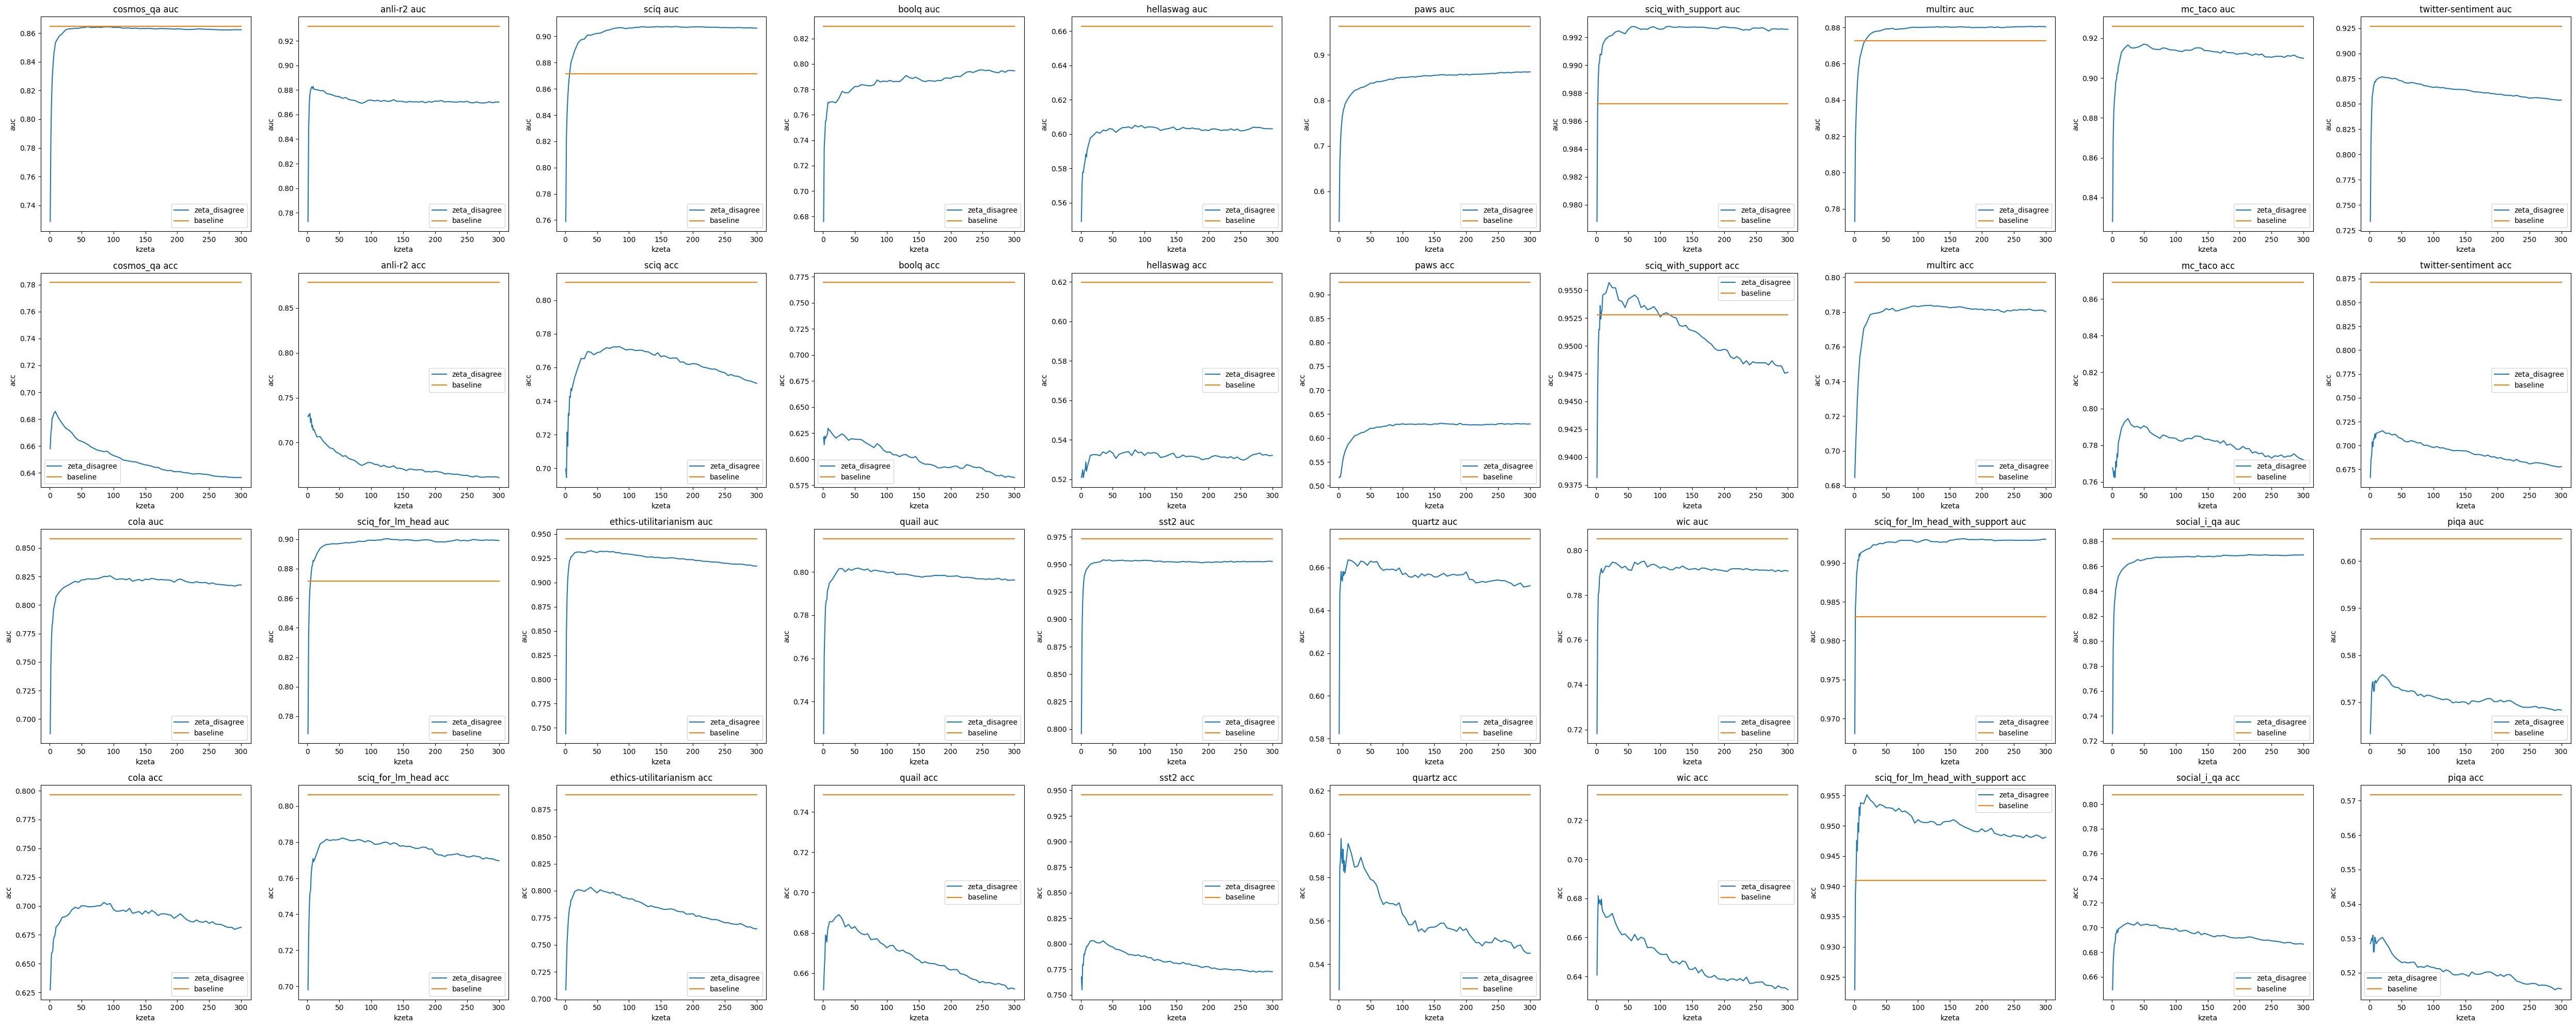

In [46]:
plot_method('zeta_disagree', 'kzeta')

num_ds: 20, num_metrics: 2


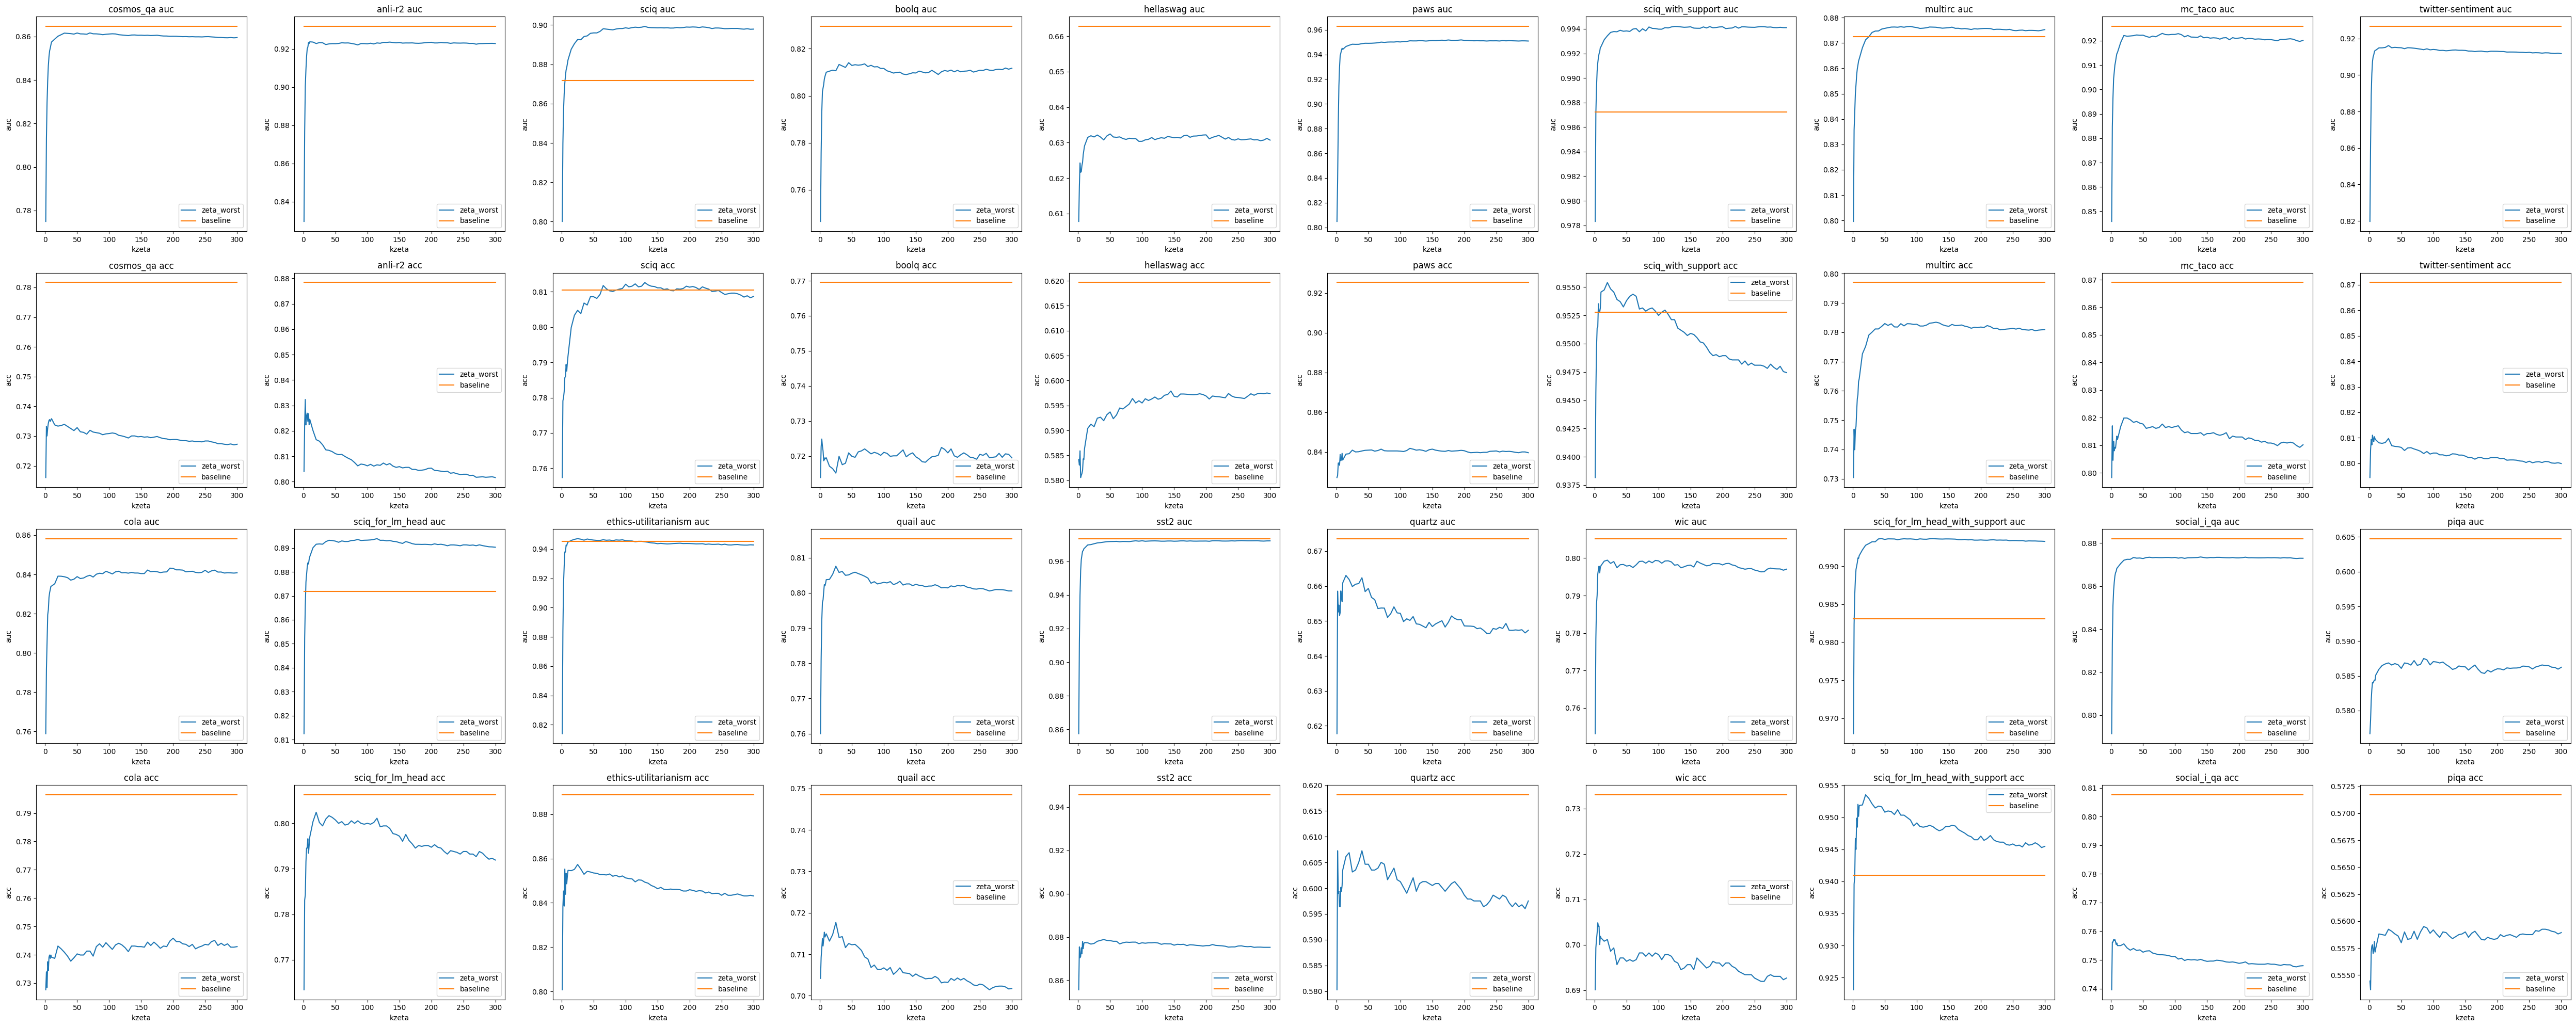

In [52]:
plot_method('zeta_worst', 'kzeta')

num_ds: 20, num_metrics: 2


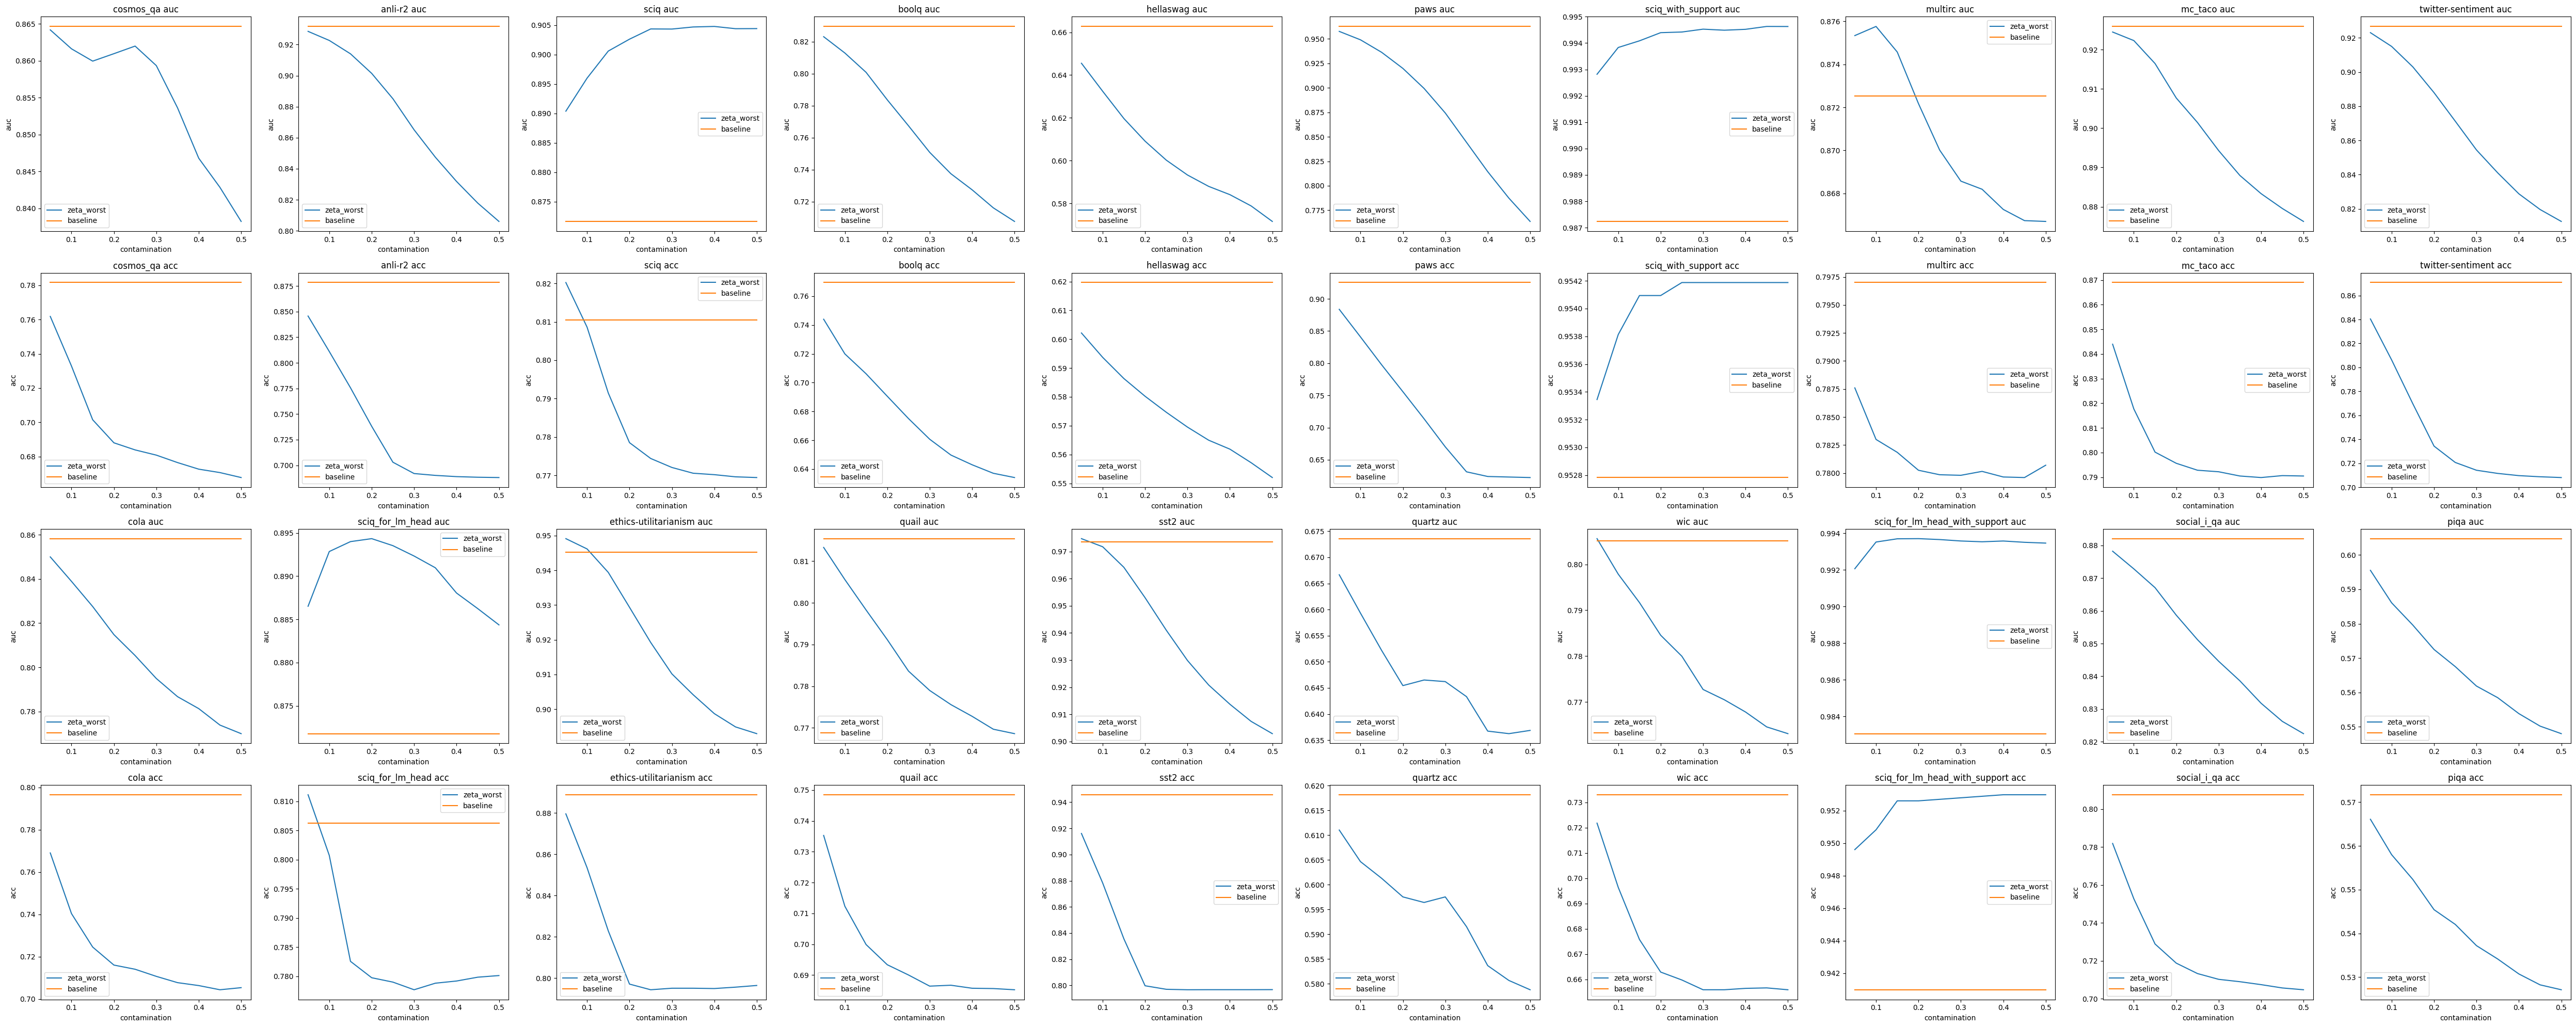

In [55]:
all_results = get_results(outfile='relabel_cont.json')
plot_method('zeta_worst', 'contamination')

# logreg

num_ds: 20, num_metrics: 2


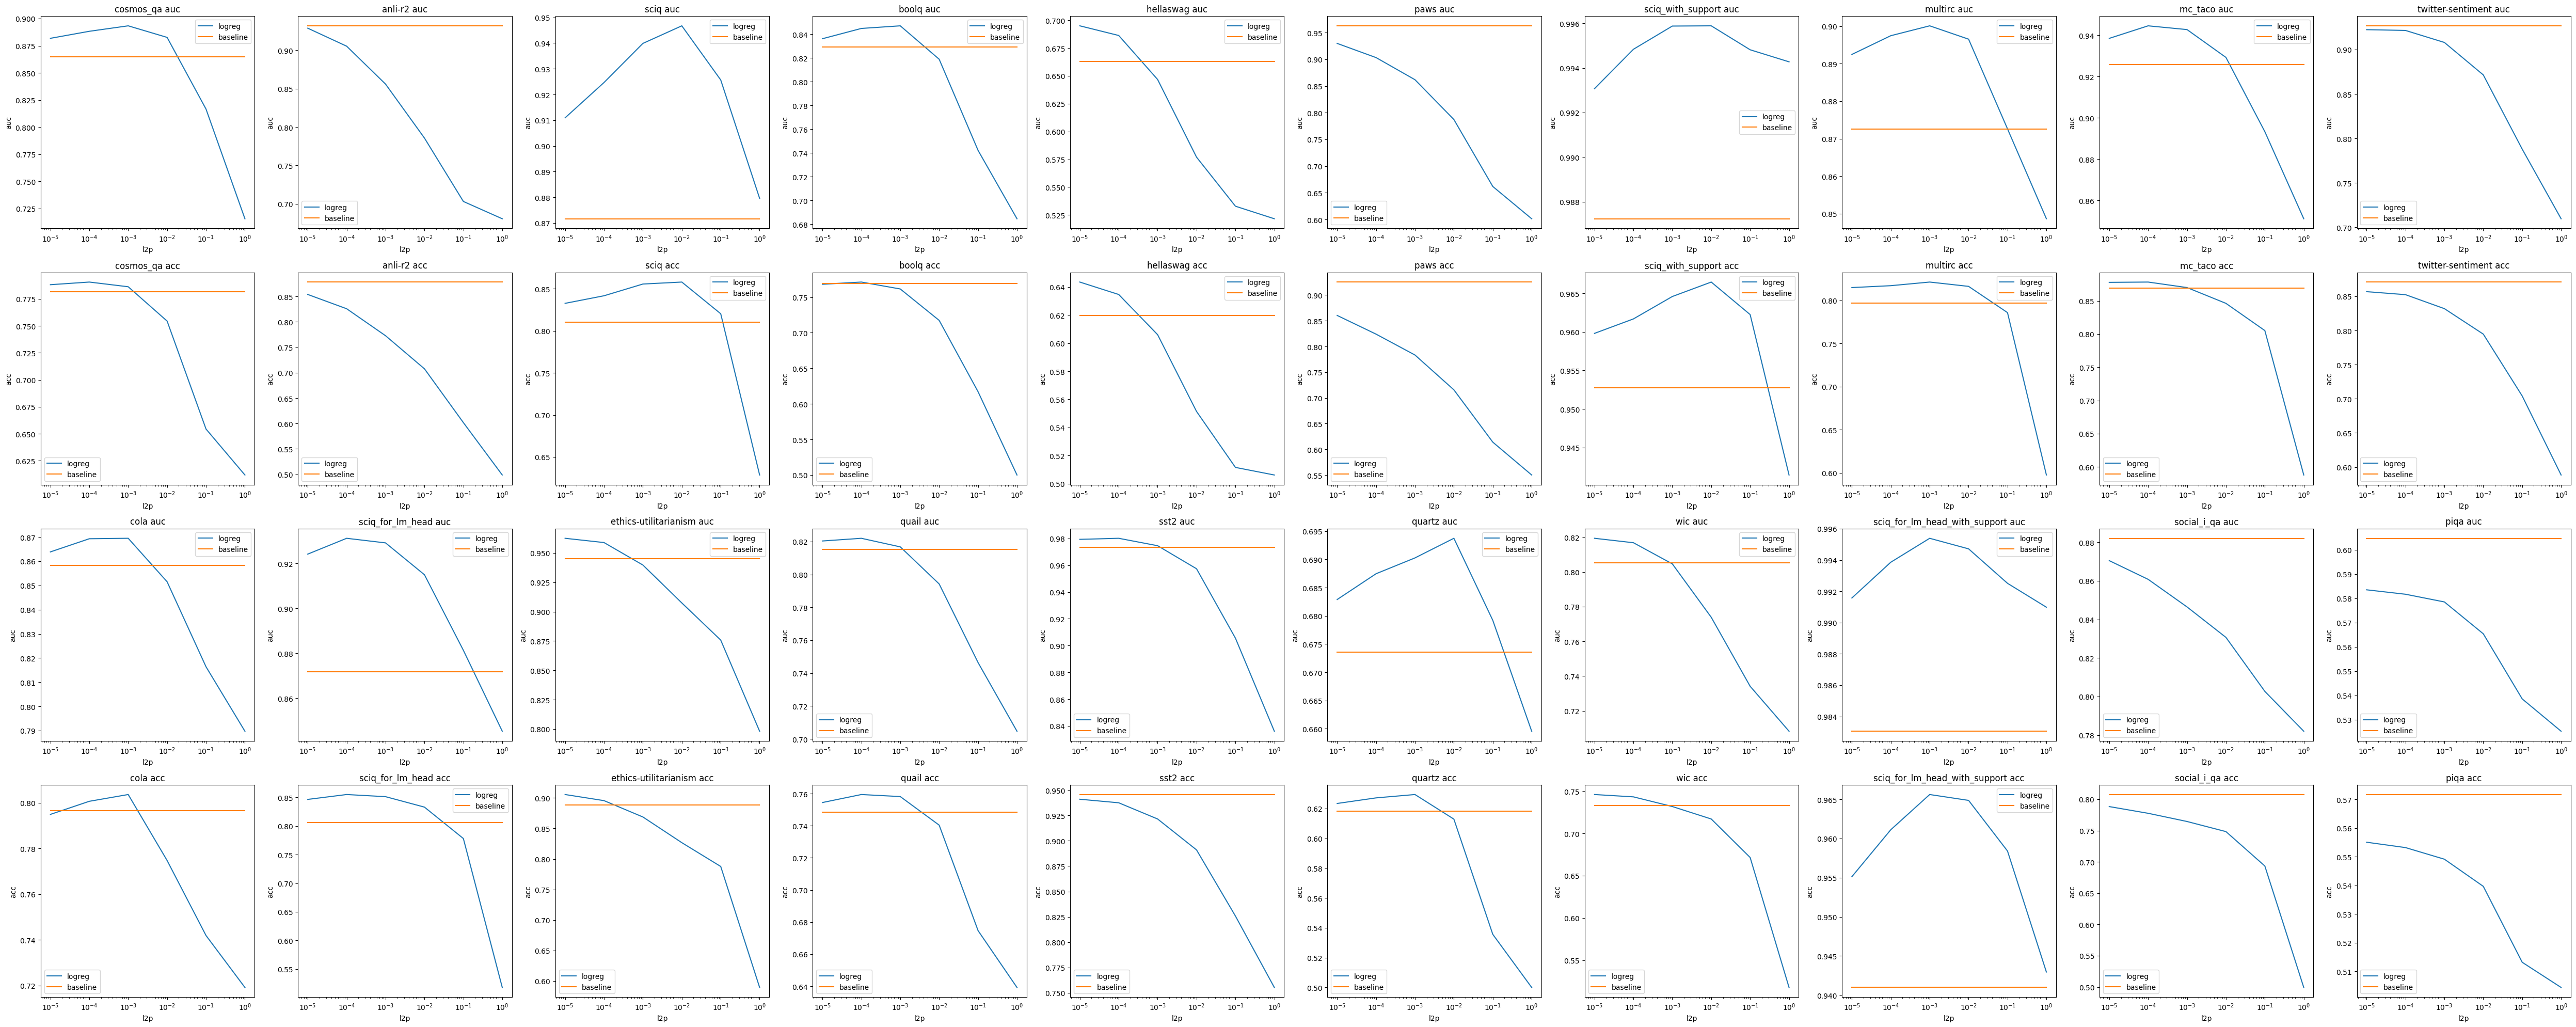

In [65]:

plot_method(get_results(), 'logreg', 'l2p', log=True)

In [8]:
l2ps

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])

In [82]:
sorted([(ds, auc_improvements[ds][1]) for ds in auc_improvements], key=lambda x: x[1])

[('paws', -0.03914535045623779),
 ('piqa', -0.021802902221679688),
 ('social_i_qa', -0.013818979263305664),
 ('anli-r2', -0.007953643798828125),
 ('twitter-sentiment', -0.004034638404846191),
 ('quail', 0.005839705467224121),
 ('sst2', 0.006355762481689453),
 ('sciq_with_support', 0.006441056728363037),
 ('cola', 0.0074661970138549805),
 ('sciq_for_lm_head_with_support', 0.009262382984161377),
 ('boolq', 0.009338676929473877),
 ('quartz', 0.01115715503692627),
 ('wic', 0.014225482940673828),
 ('mc_taco', 0.014776110649108887),
 ('ethics-utilitarianism', 0.01747143268585205),
 ('cosmos_qa', 0.018648505210876465),
 ('multirc', 0.021449685096740723),
 ('hellaswag', 0.03220105171203613),
 ('sciq', 0.04255276918411255),
 ('sciq_for_lm_head', 0.05534482002258301)]

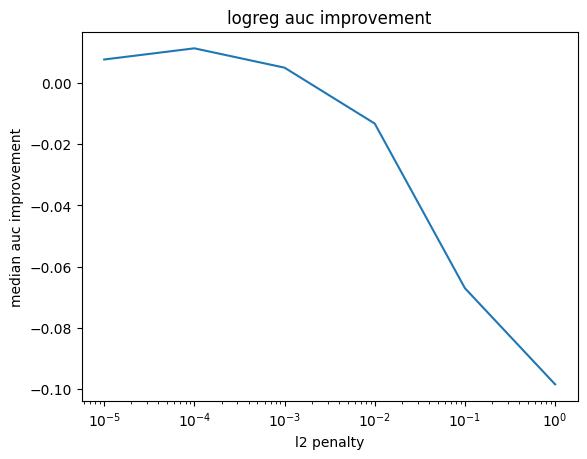

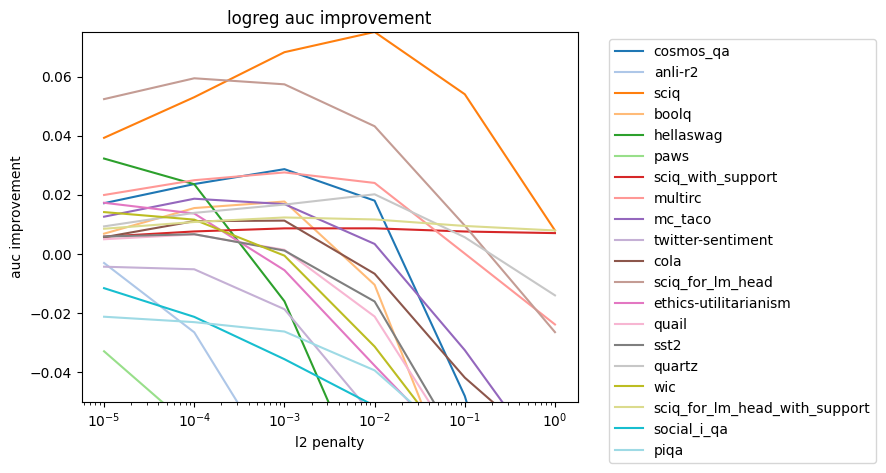

In [15]:
results = [r for r in get_results('relabel.json') if r['method'] == 'logreg']
auc_improvements = {
    r['dataset']: np.array(r['metrics']['auc']) - np.array(r['baseline_metrics']['auc'])
    for r in results
}
# median improvement for each value of l2p
l2ps = np.array(results[0]['params']['l2p'])
medians = np.median(np.array([auc_improvements[ds] for ds in auc_improvements]), axis=0)

plt.plot(l2ps * 1, medians)
plt.xscale('log')
plt.xlabel('l2 penalty')
plt.ylabel('median auc improvement')
plt.title('logreg auc improvement')
plt.show()

# plot all improvement curves
for i, (ds, improvements) in enumerate(auc_improvements.items()):
    # color and line style based on i
    plt.plot(l2ps * 1, improvements, label=ds, color=plt.cm.tab20(i))
plt.xscale('log')
plt.ylim(-0.05, 0.075)
plt.xlabel('l2 penalty')
plt.ylabel('auc improvement')
plt.title('logreg auc improvement')
# legend next to plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

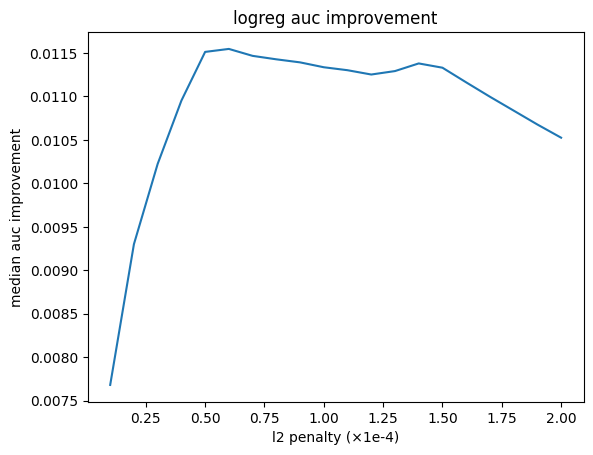

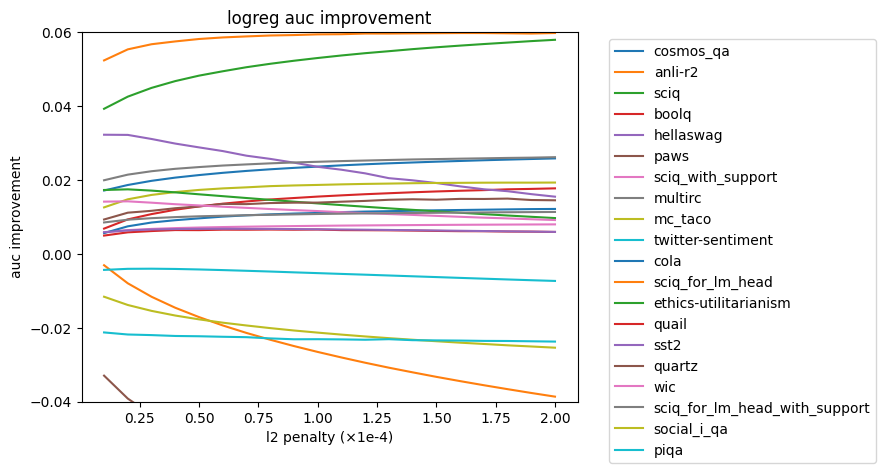

In [16]:
results = [r for r in get_results('logreg_fine.json') if r['method'] == 'logreg']
auc_improvements = {
    r['dataset']: np.array(r['metrics']['auc']) - np.array(r['baseline_metrics']['auc'])
    for r in results
}
# median improvement for each value of l2p
l2ps = np.array(results[0]['params']['l2p'])
medians = np.median(np.array([auc_improvements[ds] for ds in auc_improvements]), axis=0)

plt.plot(l2ps * 1e4, medians)
#plt.xscale('log')
plt.xlabel('l2 penalty (×1e-4)')
plt.ylabel('median auc improvement')
plt.title('logreg auc improvement')
plt.show()

# plot all improvement curves
for ds, improvements in auc_improvements.items():
    plt.plot(l2ps * 1e4, improvements, label=ds)
#plt.xscale('log')
plt.ylim(-0.04, 0.06)
plt.xlabel('l2 penalty (×1e-4)')
plt.ylabel('auc improvement')
plt.title('logreg auc improvement')
# legend next to plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [10]:
set(r['method'] for r in all_results)

{'logreg', 'zeta', 'zeta_disagree', 'zeta_null', 'zeta_worst'}

# BoolQ mystery

In [97]:
dataset = "hellaswag"

root = Path(f"/mnt/ssd-1/adam/w2s/results/{dataset}")
label_dir = root / "floor/preds"

probe_probs = torch.load(label_dir / "logreg_train.pt").cpu().detach()
wk = torch.load(root / "floor/preds/train.pt")

splits = load_and_process_dataset(dataset, split_sizes=dict(train=20_000, test=1_000))
train, test = splits["train"], splits["test"]
gt = torch.tensor(train['hard_label'])

In [98]:
wk.shape, probe_probs.shape, gt.shape

(torch.Size([20000]), torch.Size([20000]), torch.Size([20000]))

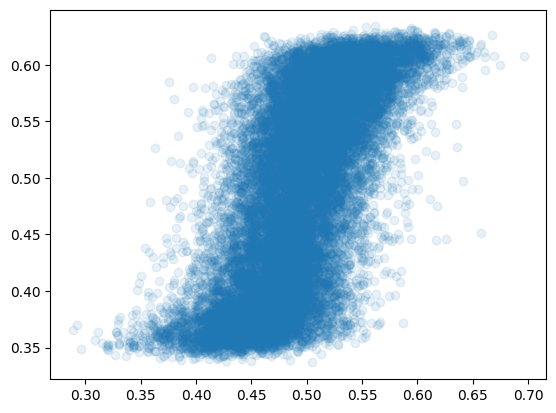

In [99]:
plt.plot(probe_probs, wk, 'o', alpha=0.1)

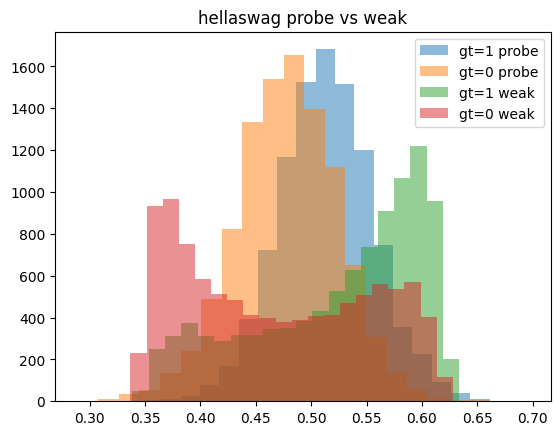

In [100]:
plt.hist(probe_probs[gt >= 0.5], bins=20, alpha=0.5, label='gt=1 probe')
plt.hist(probe_probs[gt < 0.5], bins=20, alpha=0.5, label='gt=0 probe')

plt.hist(wk[gt >= 0.5], bins=20, alpha=0.5, label='gt=1 weak')
plt.hist(wk[gt < 0.5], bins=20, alpha=0.5, label='gt=0 weak')

plt.legend()
plt.title(f'{dataset} probe vs weak')
plt.show()

In [101]:
((probe_probs > 0.5) != (wk > 0.5)).sum() / len(wk)

tensor(0.2503)

In [102]:
compute_metrics(probe_probs, gt), compute_metrics(wk, gt)

({'auc': 0.7164076566696167, 'acc': 0.6548500061035156},
 {'auc': 0.6932231187820435, 'acc': 0.642799973487854})

weak tensor(0.6429)
probe tensor(0.6586)


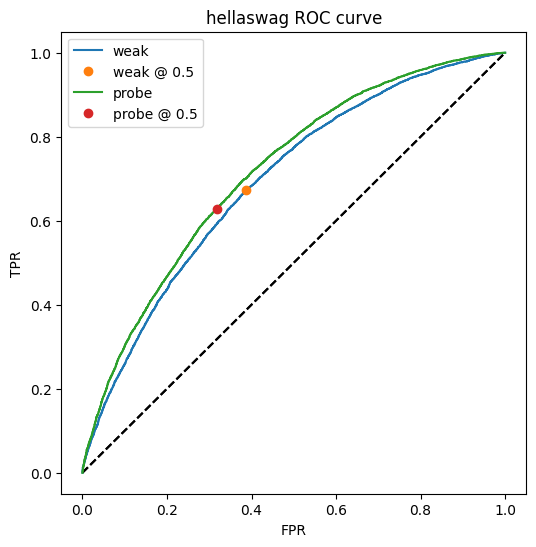

In [103]:
def plot_roc(scores, label=None):
    values, indices = torch.sort(scores, descending=True)
    TPR = (gt[indices] > 0.5).float().cumsum(0) / (gt > 0.5).sum()
    FPR = (gt[indices] < 0.5).float().cumsum(0) / (gt < 0.5).sum()

    # threshold of 0.5
    idx = (values > 0.5).nonzero()[-1]
    TPR_50 = TPR[idx]
    FPR_50 = FPR[idx]

    # add (0,0) and (1,1) to start and end
    TPR = torch.cat([torch.tensor([0]), TPR, torch.tensor([1])])
    FPR = torch.cat([torch.tensor([0]), FPR, torch.tensor([1])])

    print(label, 0.5 + 0.5 * torch.max(TPR - FPR))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(FPR, TPR, label=label)
    plt.plot(FPR_50, TPR_50, 'o', label=f'{label} @ 0.5')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'{dataset} ROC curve')

# square aspect
plt.figure(figsize=(6, 6))
plot_roc(wk, 'weak')
plot_roc(probe_probs, 'probe')
plt.legend()
plt.show()

In [79]:
# logodds
logodds = torch.log(probe_probs / (1 - probe_probs))
probe_probs.mean(), logodds.mean()

(tensor(0.5227), tensor(0.1042))

In [80]:
# logodds
logodds = torch.log(wk / (1 - wk))
wk.mean(), logodds.mean()

(tensor(0.5227), tensor(0.1116))

In [37]:
torch.tensor([1,2,3]).cumsum(0)tp

tensor([1, 3, 6])

In [32]:
auc = roc_auc(torch.tensor(random_labels), torch.tensor(random_preds))

In [33]:
auc

tensor(0.4378)

In [34]:
# compare to standard ROC AUC
from sklearn.metrics import roc_auc_score

roc_auc_score(random_labels, random_preds)

0.4377751100440176

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def xe(q, p):
    return -q * np.log(p) - (1 - q) * np.log(1 - p)

def loss(w, p, t=0.5, a=0.5):
    q = (1 - a) * w + a * (p > t)
    return xe(q, p)

/tmp/ipykernel_2608/3993756836.py:5: RuntimeWarning: divide by zero encountered in log
  return -q * np.log(p) - (1 - q) * np.log(1 - p)


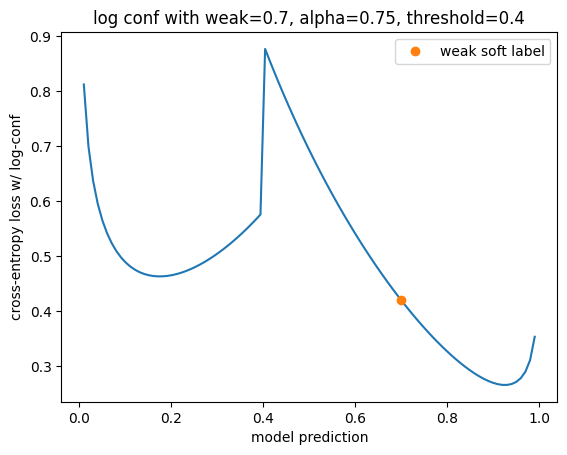

In [7]:
w, a, t = 0.7, 0.75, 0.4
plt.plot(np.linspace(0, 1, 100), loss(w, np.linspace(0, 1, 100), t, a))
plt.plot(w, loss(w, w, t, a), 'o', label='weak soft label')
plt.xlabel('model prediction')
plt.ylabel('cross-entropy loss w/ log-conf')
plt.legend()
plt.title(f'log conf with weak={w}, alpha={a}, threshold={t}')
plt.show()